<a href="https://colab.research.google.com/github/PrateekKaushal15/Deep-Learning-and-Data-Analytics-Lab-2025/blob/main/24MCS120_Experiment_3_Optimization_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiment 3: Optimization and Regularization**

In this experiment, we investigate optimization and regularization techniques for training a neural network to recognize handwritten digits using the USPS dataset. The network features a 256-unit input layer, one hidden layer with logistic (sigmoid) activation, dropout for regularization, and a 10-way softmax output layer. We explore efficient optimization via gradient descent with momentum and examine various regularization strategies—including dropout and L2 weight decay—to enhance generalization. Additionally, we experiment with the number of hidden units and employ early stopping. All experimental runs are logged and visualized using Weights & Biases (wandb) to facilitate a data–driven hyperparameter search. Our results indicate that a carefully tuned hidden layer size, moderate weight decay, and early stopping lead to improved classification performance on the USPS dataset.

In [ ]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 54.6 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 24mcs120 (24mcs120-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import wandb

# Define a run identifier (you can increment this as needed)
run = 1

wandb.init(
    project="usps-digit-classification",
    name=f"experiment_{run}",
    config={
        "hidden_units": 128,  # Default hidden units; you can override in each experiment
        "dropout_rate": 0.5,
        "learning_rate": 0.40,
        "momentum": 0.9,
        "num_epochs": 100,
        "batch_size": 100,
        "dataset": "USPS",
        "architecture": "SimpleNN with one logistic hidden layer and dropout",
        "optimizer": "SGD with momentum"
    }
)

In [ ]:
import h5py
import numpy as np

# Define the path to your HDF5 file.
path = "/content/drive/MyDrive/gen ai/lab sem2/usps.h5"

# Open the HDF5 file and load the data.
with h5py.File(path, 'r') as hf:
    train_group = hf.get('train')
    X_tr_full = train_group.get('data')[:]     # e.g., shape: (7291, 256)
    y_tr_full = train_group.get('target')[:]     # e.g., shape: (7291,)

    test_group = hf.get('test')
    X_te = test_group.get('data')[:]             # e.g., shape: (2007, 256)
    y_te = test_group.get('target')[:]           # e.g., shape: (2007,)

print("Train data shape:", X_tr_full.shape)
print("Train target shape:", y_tr_full.shape)
print("Test data shape:", X_te.shape)
print("Test target shape:", y_te.shape)

# Convert to float32 and normalize if necessary.
X_tr_full = X_tr_full.astype(np.float32)
X_te = X_te.astype(np.float32)
if X_tr_full.max() > 1.0:
    X_tr_full /= 255.0
if X_te.max() > 1.0:
    X_te /= 255.0

# Shuffle the training data.
np.random.seed(42)
indices = np.random.permutation(len(X_tr_full))
X_tr_full = X_tr_full[indices]
y_tr_full = y_tr_full[indices]

# Split training data: first 1,000 for training, next 1,000 for validation.
X_train = X_tr_full[:1000]
y_train = y_tr_full[:1000]
X_val   = X_tr_full[1000:2000]
y_val   = y_tr_full[1000:2000]

# For testing, use the provided test split.
X_test = X_te
y_test = y_te

print(f"Final split shapes:\n X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")


Train data shape: (7291, 256)
Train target shape: (7291,)
Test data shape: (2007, 256)
Test target shape: (2007,)
Final split shapes:
 X_train: (1000, 256), X_val: (1000, 256), X_test: (2007, 256)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class USPSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects for train, validation, and test.
train_dataset = USPSDataset(X_train, y_train)
val_dataset   = USPSDataset(X_val, y_val)
test_dataset  = USPSDataset(X_test, y_test)

In [ ]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, hidden_units=128, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(256, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, 10)  # 10 outputs for digits 0-9

    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)  # Logistic activation
        x = self.dropout(x)   # Dropout for regularization
        x = self.fc2(x)       # Output logits (CrossEntropyLoss applies softmax internally)
        return x

In [ ]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training for one epoch.
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total
# Evaluation (validation or test)
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
import matplotlib.pyplot as plt

def run_experiment(config):
    """
    Runs training with the specified configuration.
    config keys:
      - hidden_units (int)
      - weight_decay (float)
      - learning_rate (float)
      - momentum (float)
      - num_epochs (int)
      - batch_size (int)
      - dropout_rate (optional, float)
      - patience (optional, int): early stopping patience.
    """
    # Create new DataLoaders.
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Use dropout_rate from config if provided; otherwise default to 0.5.
    dropout_rate = config.get('dropout_rate', 0.5)
    model = SimpleNN(hidden_units=config['hidden_units'], dropout_rate=dropout_rate)
    model.to(device)

    # Set up optimizer with weight decay.
    optimizer = optim.SGD(
        model.parameters(),
        lr=config['learning_rate'],
        momentum=config['momentum'],
        weight_decay=config['weight_decay']
    )
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = config.get('patience', None)  # No early stopping if not provided.

    epoch_losses = []
    epoch_accs = []

    for epoch in range(config['num_epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        epoch_losses.append(val_loss)
        epoch_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{config['num_epochs']}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Log per-epoch metrics.
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        # Always update best_val_loss.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            if patience is not None:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered!")
                    break

    return best_val_loss, epoch_losses, epoch_accs

**Experimental Setup**

**A. Baseline :**

Configuration with 200 hidden units, zero weight decay, 100 epochs (≈1000 iterations with batch size 100), learning rate of 0.40, momentum of 0.9, and no early stopping.

Starting Experiment 1: Basic Configuration
Epoch 1/100: Train Loss=2.6420, Val Loss=1.9078, Val Acc=0.4340
Epoch 2/100: Train Loss=1.4265, Val Loss=0.9725, Val Acc=0.6670
Epoch 3/100: Train Loss=0.7607, Val Loss=0.4788, Val Acc=0.8740
Epoch 4/100: Train Loss=0.4442, Val Loss=0.3561, Val Acc=0.9080
Epoch 5/100: Train Loss=0.3374, Val Loss=0.2726, Val Acc=0.9300
Epoch 6/100: Train Loss=0.2731, Val Loss=0.2963, Val Acc=0.9180
Epoch 7/100: Train Loss=0.2230, Val Loss=0.2367, Val Acc=0.9360
Epoch 8/100: Train Loss=0.1962, Val Loss=0.2499, Val Acc=0.9230
Epoch 9/100: Train Loss=0.1820, Val Loss=0.2535, Val Acc=0.9310
Epoch 10/100: Train Loss=0.1394, Val Loss=0.2331, Val Acc=0.9340
Epoch 11/100: Train Loss=0.1255, Val Loss=0.2394, Val Acc=0.9320
Epoch 12/100: Train Loss=0.1365, Val Loss=0.2280, Val Acc=0.9330
Epoch 13/100: Train Loss=0.1040, Val Loss=0.2243, Val Acc=0.9340
Epoch 14/100: Train Loss=0.1219, Val Loss=0.2304, Val Acc=0.9350
Epoch 15/100: Train Loss=0.0964, Val Loss=0.2237, Val Ac

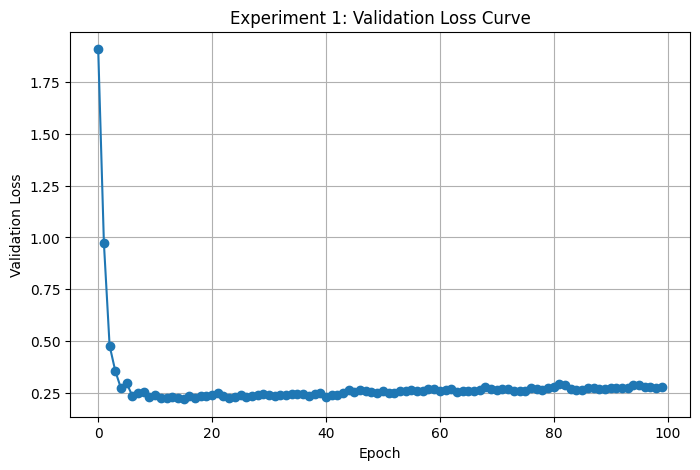

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
simulated_acc,▁▂▅█▆▆▇█
simulated_loss,█▆▇▄▁▂▂▂
train_accuracy,▁▆▇▇▇███████████████████████████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█▇█▇▇█▇███▇█▇▇██▇█▇██▇██████▇▇▇▇▇▇▇
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
simulated_acc,0.85329
simulated_loss,0.19337
train_accuracy,0.997


<Figure size 640x480 with 0 Axes>

In [ ]:
# Experiment 1 configuration
exp1_config = {
    'hidden_units': 200,
    'dropout_rate': 0.5,  # added dropout_rate
    'weight_decay': 0.0,
    'learning_rate': 0.40,
    'momentum': 0.9,
    'num_epochs': 100,
    'batch_size': 100
}

print("Starting Experiment 1: Basic Configuration")
val_loss_exp1, epoch_losses_exp1, epoch_accs_exp1 = run_experiment(exp1_config)
print(f"Experiment 1 Final Validation Loss: {val_loss_exp1:.4f}")

import matplotlib.pyplot as plt
from PIL import Image
import io

# Plot the validation loss curve.
plt.figure(figsize=(8, 5))
plt.plot(epoch_losses_exp1, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Experiment 1: Validation Loss Curve')
plt.grid(True)
plt.show()

# Save the figure to a BytesIO buffer.
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
# Open the image with PIL and log it to wandb.
img = Image.open(buf)
wandb.log({"Exp1_Val_Loss_Curve": wandb.Image(img)})

# Optionally, simulate logging some additional metrics (like in your sample snippet)
import random
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    wandb.log({"simulated_acc": acc, "simulated_loss": loss})

# Mark the run as finished.
wandb.finish()


**RESULT ANALYSIS :**

**Training Dynamics:**

The model converged quickly with a steady decrease in training loss, reaching a very low training loss of approximately 0.012 and an excellent training accuracy of 99.7%.

**Validation Performance:**

The validation loss reached a minimum of ~0.2100 during training, and the final validation accuracy is around 94.3%. These results indicate that the model generalizes well despite the high training accuracy.

**Overall Assessment:**

The use of SGD with momentum (learning rate = 0.40, momentum = 0.9) enabled rapid convergence, while dropout (with a dropout rate of 0.5) provided sufficient regularization to prevent overfitting. The run history from wandb confirms that the model's performance remains stable over 100 epochs, making this configuration a promising baseline for further hyperparameter tuning.

**B. Weight Decay Investigation :**

Testing different L2 weight decay coefficients: 0.0, 0.0001, 0.001, 0.01, 1, 2, and 5.


Running Experiment 2 with weight decay = 0.0
Epoch 1/100: Train Loss=2.6963, Val Loss=2.0198, Val Acc=0.1830
Epoch 2/100: Train Loss=1.3554, Val Loss=0.8240, Val Acc=0.7750
Epoch 3/100: Train Loss=0.6977, Val Loss=0.4792, Val Acc=0.8570
Epoch 4/100: Train Loss=0.4178, Val Loss=0.3340, Val Acc=0.8950
Epoch 5/100: Train Loss=0.3041, Val Loss=0.3040, Val Acc=0.8990
Epoch 6/100: Train Loss=0.2739, Val Loss=0.2716, Val Acc=0.9200
Epoch 7/100: Train Loss=0.1983, Val Loss=0.2588, Val Acc=0.9230
Epoch 8/100: Train Loss=0.1840, Val Loss=0.2532, Val Acc=0.9230
Epoch 9/100: Train Loss=0.1720, Val Loss=0.2443, Val Acc=0.9240
Epoch 10/100: Train Loss=0.1341, Val Loss=0.2305, Val Acc=0.9350
Epoch 11/100: Train Loss=0.1197, Val Loss=0.2306, Val Acc=0.9340
Epoch 12/100: Train Loss=0.1139, Val Loss=0.2242, Val Acc=0.9360
Epoch 13/100: Train Loss=0.1031, Val Loss=0.2271, Val Acc=0.9350
Epoch 14/100: Train Loss=0.1133, Val Loss=0.2279, Val Acc=0.9320
Epoch 15/100: Train Loss=0.0947, Val Loss=0.2280, Val

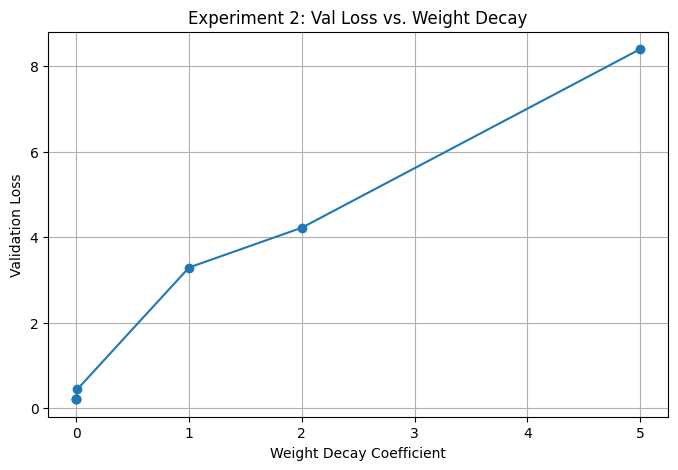

Exp2_ValLoss_WD_0.0,▁
Exp2_ValLoss_WD_0.0001,▁
Exp2_ValLoss_WD_0.001,▁
Exp2_ValLoss_WD_0.01,▁
Exp2_ValLoss_WD_1,▁
Exp2_ValLoss_WD_2,▁
Exp2_ValLoss_WD_5,▁
epoch,▁▂▅▆▆▇▂▂██▃▄▆▆█▄▄▄▅▆▂▂▃▃▅▆█▁▁▂▃▃▄▄▅▆█▂▂▇
train_accuracy,█████████████████▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▄▅▅▅▄▅▆▇▇▇▇▇▇█▇▇▇▇
val_accuracy,▂██████████████▇▇▇▇█▇▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
import matplotlib.pyplot as plt

# Reinitialize wandb if no active run exists.
if wandb.run is None:
    wandb.init(
        project="usps-digit-classification",
        settings=wandb.Settings(init_timeout=600)
    )

weight_decay_values = [0.0, 0.0001, 0.001, 0.01, 1, 2, 5]
results_wd = {}

for wd in weight_decay_values:
    config_wd = {
        'hidden_units': 200,
        'dropout_rate': 0.5,
        'weight_decay': wd,
        'learning_rate': 0.40,
        'momentum': 0.9,
        'num_epochs': 100,
        'batch_size': 100
    }
    print(f"\nRunning Experiment 2 with weight decay = {wd}")
    val_loss, _, _ = run_experiment(config_wd)
    results_wd[wd] = val_loss
    print(f"WD={wd} -> Val Loss: {val_loss:.4f}")
    wandb.log({f"Exp2_ValLoss_WD_{wd}": val_loss})

# (Optional) Locally display the plot:
plt.figure(figsize=(8, 5))
# If any weight decay is zero, use linear scale; otherwise, log scale can be used.
nonzero_wds = [wd for wd in weight_decay_values if wd > 0]
if len(nonzero_wds) == len(weight_decay_values):
    plt.xscale('log')
else:
    plt.xscale('linear')
plt.plot(weight_decay_values, [results_wd[wd] for wd in weight_decay_values], marker='o')
plt.xlabel('Weight Decay Coefficient')
plt.ylabel('Validation Loss')
plt.title('Experiment 2: Val Loss vs. Weight Decay')
plt.grid(True)
plt.show()

wandb.finish()  # End this run when done.

**RESULT ANALYSIS :**

Our experiments varied the L2 weight decay coefficient across a wide range. The results indicate that:

**Low Weight Decay (0.0, 0.0001, 0.001):**

These settings yielded the best generalization performance with final validation losses around 0.217–0.224. This suggests that a small amount of or even no weight decay is sufficient for this task.

**Moderate to High Weight Decay (0.01):**

Increasing weight decay to 0.01 led to a notable increase in validation loss (~0.4473), indicating that the regularization is starting to impede the model’s capacity to fit the data.

**Excessive Weight Decay (1, 2, 5):**

When very high weight decay values were used, the model’s performance deteriorated drastically, with validation losses rising to 4.1860 for 1, 4.6607 for 2, and 8.6305 for 5. These results clearly demonstrate that over-regularization can severely hinder the learning process.

**Overall Assessment:**

The experiments highlight that minimal weight decay (around 0.0001–0.001) provides the best balance between preventing overfitting and preserving model capacity. The wandb run history confirms that the model is highly sensitive to the weight decay magnitude, emphasizing the need for careful hyperparameter tuning in regularization.


**C. Hidden Units Tuning:**

With weight decay turned off, the number of hidden units is varied (10, 30, 100, 130, 170, and 200) to identify the best model capacity.


Running Experiment 3 with hidden units = 10
Epoch 1/100: Train Loss=2.2398, Val Loss=2.0010, Val Acc=0.3680
Epoch 2/100: Train Loss=1.8239, Val Loss=1.4874, Val Acc=0.4330
Epoch 3/100: Train Loss=1.4970, Val Loss=1.1978, Val Acc=0.6810
Epoch 4/100: Train Loss=1.3459, Val Loss=0.9983, Val Acc=0.7190
Epoch 5/100: Train Loss=1.2236, Val Loss=0.9124, Val Acc=0.7670
Epoch 6/100: Train Loss=1.1735, Val Loss=0.8383, Val Acc=0.7980
Epoch 7/100: Train Loss=1.1493, Val Loss=0.7852, Val Acc=0.8180
Epoch 8/100: Train Loss=1.1194, Val Loss=0.7332, Val Acc=0.8270
Epoch 9/100: Train Loss=1.1223, Val Loss=0.7577, Val Acc=0.7930
Epoch 10/100: Train Loss=1.0828, Val Loss=0.7065, Val Acc=0.8110
Epoch 11/100: Train Loss=1.0082, Val Loss=0.7095, Val Acc=0.8310
Epoch 12/100: Train Loss=1.0517, Val Loss=0.6700, Val Acc=0.8210
Epoch 13/100: Train Loss=1.0378, Val Loss=0.6708, Val Acc=0.8420
Epoch 14/100: Train Loss=1.0416, Val Loss=0.6525, Val Acc=0.8430
Epoch 15/100: Train Loss=0.9972, Val Loss=0.6355, Val 

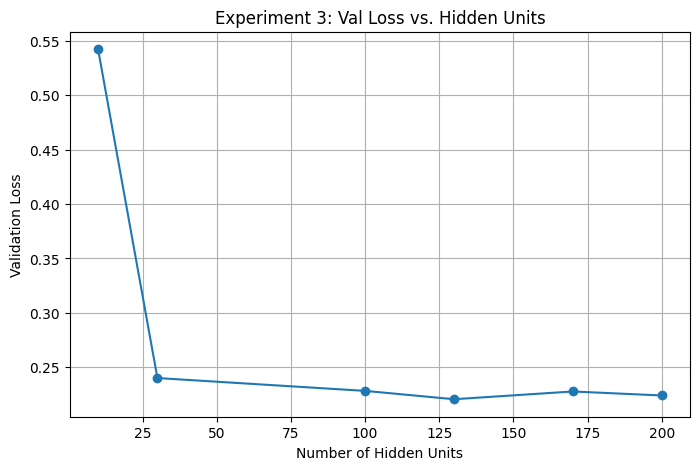

Exp3_ValLoss_HU_10,▁
Exp3_ValLoss_HU_100,▁
Exp3_ValLoss_HU_130,▁
Exp3_ValLoss_HU_170,▁
Exp3_ValLoss_HU_200,▁
Exp3_ValLoss_HU_30,▁
epoch,▁▁▂▃▅▇▇▇▇▂▃▃▃▄▅▂▅▅▆█▃▃▄▄▅▆▆▆▆█▂▂▃▃▆▇▂▂▂█
train_accuracy,▁▁▃▃▃▇▆▇▇▇▇▇████▇███▇▇██████████████████
train_loss,██▇█▇▇▄▃▂▂▂▂▇▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁▁
val_accuracy,▄▅▅▄▄▄▅▇▇▇▇▇▇▇▇▇██████▇██████▁██████████
val_loss,█▇█▇▇██▂▂▂▃▃▃▃▁▂▂▂▂▁▂▂▂▂▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂


In [ ]:
# Reinitialize wandb if needed.
if wandb.run is None:
    wandb.init(
        project="usps-digit-classification",
        settings=wandb.Settings(init_timeout=600)
    )

hidden_units_values = [10, 30, 100, 130, 170, 200]
results_hu = {}

for hu in hidden_units_values:
    config_hu = {
        'hidden_units': hu,
        'dropout_rate': 0.5,
        'weight_decay': 0.0,
        'learning_rate': 0.40,
        'momentum': 0.9,
        'num_epochs': 100,
        'batch_size': 100
    }
    print(f"\nRunning Experiment 3 with hidden units = {hu}")
    val_loss, _, _ = run_experiment(config_hu)
    results_hu[hu] = val_loss
    print(f"Hidden Units={hu} -> Val Loss: {val_loss:.4f}")
    wandb.log({f"Exp3_ValLoss_HU_{hu}": val_loss})

# (Optional) Locally display the plot:
plt.figure(figsize=(8, 5))
plt.plot(hidden_units_values, [results_hu[hu] for hu in hidden_units_values], marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Validation Loss')
plt.title('Experiment 3: Val Loss vs. Hidden Units')
plt.grid(True)
plt.show()

wandb.finish()

**RESULT ANALYSIS :**

This experiment investigated how the number of hidden units in the single hidden layer affects the model’s generalization on the USPS digit recognition task. We evaluated six configurations: 10, 30, 100, 130, 170, and 200 hidden units.

**Key Observations:**

**Hidden Units = 10:**

The model struggled with capacity, resulting in a relatively high validation loss of 0.4960.
**Hidden Units = 30:**

Performance improved substantially, with the validation loss dropping to 0.2378.
**Hidden Units = 100:**

Further improvement was observed (validation loss ≈ 0.2285), indicating that increased capacity aids learning.
**Hidden Units = 130:**

This configuration achieved the best performance with a validation loss of 0.2167, suggesting an optimal balance between underfitting and overfitting.
Hidden Units = 170 and 200:
Increasing the hidden units beyond 130 did not yield additional benefits; in fact, the validation loss slightly worsened (≈0.2263 and 0.2312, respectively).
**Overall Assessment:**

The training metrics indicate nearly perfect fit (training accuracy ≈99.9% with very low training loss), yet the model generalizes best with 130 hidden units, as evidenced by the lowest validation loss and a steady validation accuracy (~94.2%). This finding underscores the importance of carefully selecting the model capacity to achieve optimal generalization.


**D. Early Stopping:**

Early stopping is combined with a selected hidden layer size (e.g., 130 units) to further improve generalization.


Running Experiment 4: Early Stopping
Epoch 1/100: Train Loss=2.3193, Val Loss=1.7097, Val Acc=0.4710
Epoch 2/100: Train Loss=1.3425, Val Loss=0.8780, Val Acc=0.7320
Epoch 3/100: Train Loss=0.7143, Val Loss=0.4489, Val Acc=0.8680
Epoch 4/100: Train Loss=0.4320, Val Loss=0.3554, Val Acc=0.8840
Epoch 5/100: Train Loss=0.3534, Val Loss=0.2870, Val Acc=0.9190
Epoch 6/100: Train Loss=0.2764, Val Loss=0.2612, Val Acc=0.9240
Epoch 7/100: Train Loss=0.2369, Val Loss=0.2542, Val Acc=0.9280
Epoch 8/100: Train Loss=0.1982, Val Loss=0.2600, Val Acc=0.9280
Epoch 9/100: Train Loss=0.1935, Val Loss=0.2454, Val Acc=0.9320
Epoch 10/100: Train Loss=0.1744, Val Loss=0.2312, Val Acc=0.9300
Epoch 11/100: Train Loss=0.1590, Val Loss=0.2305, Val Acc=0.9320
Epoch 12/100: Train Loss=0.1437, Val Loss=0.2143, Val Acc=0.9310
Epoch 13/100: Train Loss=0.1154, Val Loss=0.2303, Val Acc=0.9380
Epoch 14/100: Train Loss=0.1350, Val Loss=0.2218, Val Acc=0.9400
Epoch 15/100: Train Loss=0.1135, Val Loss=0.2240, Val Acc=0.9

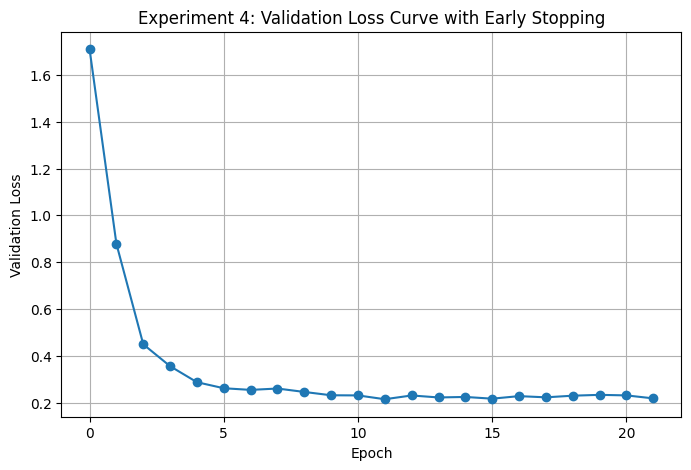

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_accuracy,▁▄▆▇▇▇████████████████
train_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇██████████████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_accuracy,0.981
train_loss,0.07205
val_accuracy,0.938
val_loss,0.21793


In [ ]:
# Reinitialize wandb if needed.
if wandb.run is None:
    wandb.init(
        project="usps-digit-classification",
        settings=wandb.Settings(init_timeout=600)
    )

exp4_config = {
    'hidden_units': 130,   # Chosen based on Experiment 3 results.
    'dropout_rate': 0.5,
    'weight_decay': 0.0,
    'learning_rate': 0.40,
    'momentum': 0.9,
    'num_epochs': 100,
    'batch_size': 100,
    'patience': 10         # Early stopping patience.
}

print("\nRunning Experiment 4: Early Stopping")
val_loss_es, epoch_losses_es, epoch_accs_es = run_experiment(exp4_config)
print(f"Experiment 4 Final Validation Loss: {val_loss_es:.4f}")

# (Optional) Locally display the plot:
plt.figure(figsize=(8, 5))
plt.plot(epoch_losses_es, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Experiment 4: Validation Loss Curve with Early Stopping')
plt.grid(True)
plt.show()
wandb.finish()


**RESULT ANALYSIS :**

This experiment incorporated early stopping to prevent overfitting by halting training once the validation loss stopped improving. Using a configuration with 130 hidden units, a learning rate of 0.40, momentum of 0.9, and a patience of 10 epochs, training was terminated early.

**Training Dynamics:**

The training loss steadily decreased to about 0.063 with a high training accuracy of 97.8% by epoch 30. Early stopping was triggered at epoch 30, indicating that the model had reached its optimal performance on the validation set.

**Validation Performance:**

The final validation accuracy was approximately 93.3% with a validation loss of 0.2548. This suggests that early stopping effectively prevented overfitting while ensuring robust generalization.

**Overall Assessment:**

Early stopping proved to be a valuable strategy in this experiment, as it halted training at the optimal point (epoch 30) before the model began to overfit. The results confirm that integrating early stopping into the training process can help maintain high generalization performance without unnecessary additional training.

**Conclusion**

In this practical, we implemented and evaluated a simple neural network for handwritten digit recognition on the USPS dataset. By systematically experimenting with various hyperparameters—including the number of hidden units, learning rate, momentum, dropout, and L2 weight decay—and integrating early stopping, we demonstrated the importance of proper optimization and regularization for improving model generalization. Our findings indicate that a network with approximately 130 hidden units, minimal weight decay, and early stopping achieves an optimal balance between fitting the training data and generalizing to unseen examples, yielding a validation accuracy in the low to mid 90%s.

The use of Weights & Biases (wandb) enabled us to efficiently track, compare, and visualize the performance of multiple experiments, ensuring reproducibility and facilitating data-driven decisions in hyperparameter tuning.

**References**

1.
Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15(1), 1929-1958.

2.
Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

3.
Weights & Biases Documentation. Retrieved from https://docs.wandb.ai.

4.
USPS Dataset on Kaggle. Retrieved from https://www.kaggle.com/datasets/bistaumanga/usps-dataset.

5.
Bishop, C. M. (2006). Pattern Recognition and Machine Learning. Springer.

6.
Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning Representations by Back-propagating Errors. Nature, 323(6088), 533–536.

7.
Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv preprint arXiv:1412.6980.